In [232]:
"""
copyright: abhirup.ghosh.184098@gmail.com
"""

# dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
from matplotlib.gridspec import GridSpec
import geopandas as gpd

import matplotlib as mpl
import seaborn as sns

import matplotlib.image as mpimg
import imageio

plt.style.use('ggplot')
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams["savefig.facecolor"] = mpl.rcParams["axes.facecolor"]
import os

# Loading Data

## Reservations (trimmed)

In [233]:
df = pd.read_csv('../data/taxi_trips_201905_trimmed.csv', parse_dates=['Trip Start Timestamp', 'Trip End Timestamp'])
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1532337 entries, 0 to 1532336
Data columns (total 7 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   Taxi ID                     1532311 non-null  object        
 1   Trip Start Timestamp        1532337 non-null  datetime64[ns]
 2   Trip End Timestamp          1532249 non-null  datetime64[ns]
 3   Trip Miles                  1532287 non-null  float64       
 4   Trip Total                  1532192 non-null  float64       
 5   Pickup Centroid Location    1423976 non-null  object        
 6   Dropoff Centroid  Location  1393999 non-null  object        
dtypes: datetime64[ns](2), float64(2), object(3)
memory usage: 81.8+ MB


,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Miles,Trip Total,Pickup Centroid Location,Dropoff Centroid Location
0,7499f31aeb2596448038b2c295983f4d67aa22ac46a668...,2019-05-01,2019-05-01 00:00:00,0.0,50.00,NaN,NaN
1,8bdfcf458813980ab6b1ba8a933ed7a3702178368ade6b...,2019-05-01,2019-05-01 00:00:00,0.0,7.75,NaN,NaN
2,c2e7642922627884ea6e26885d164bc342c94110efc234...,2019-05-01,2019-05-01 00:30:00,12.7,41.25,NaN,POINT (-87.6558787862 41.96581197)
3,8e9243d940d949ed3588e8ee5254eef4ba11ae19b30d99...,2019-05-01,2019-05-01 00:00:00,0.0,4.75,NaN,NaN
4,9458348b38e6b327b2d8fc070b05551916fd95da48ea13...,2019-05-01,2019-05-01 00:15:00,11.6,41.70,POINT (-87.7696154528 41.7925923603),POINT (-87.6251921424 41.8788655841)


## Chicago: Map

In [234]:
chi = gpd.read_file('../data/chicago.geojson')
chi.info()
chi.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   name        98 non-null     object             
 1   cartodb_id  98 non-null     int64              
 2   created_at  98 non-null     datetime64[ns, UTC]
 3   updated_at  98 non-null     datetime64[ns, UTC]
 4   geometry    98 non-null     geometry           
dtypes: datetime64[ns, UTC](2), geometry(1), int64(1), object(1)
memory usage: 4.0+ KB


,name,cartodb_id,created_at,updated_at,geometry
0,Grand Boulevard,1,2013-02-02 23:59:44.022000+00:00,2013-02-02 23:59:44.295000+00:00,"MULTIPOLYGON (((-87.60671 41.81681, -87.60671 ..."
1,Printers Row,2,2013-02-02 23:59:44.022000+00:00,2013-02-02 23:59:44.295000+00:00,"MULTIPOLYGON (((-87.62761 41.87437, -87.62759 ..."
2,United Center,3,2013-02-02 23:59:44.022000+00:00,2013-02-02 23:59:44.295000+00:00,"MULTIPOLYGON (((-87.66707 41.88885, -87.66707 ..."
3,Sheffield & DePaul,4,2013-02-02 23:59:44.022000+00:00,2013-02-02 23:59:44.295000+00:00,"MULTIPOLYGON (((-87.65833 41.92166, -87.65835 ..."
4,Humboldt Park,5,2013-02-02 23:59:44.022000+00:00,2013-02-02 23:59:44.295000+00:00,"MULTIPOLYGON (((-87.74060 41.88782, -87.74060 ..."


(-87.96091285, -87.50333814999999, 41.6256182, 42.0419638)

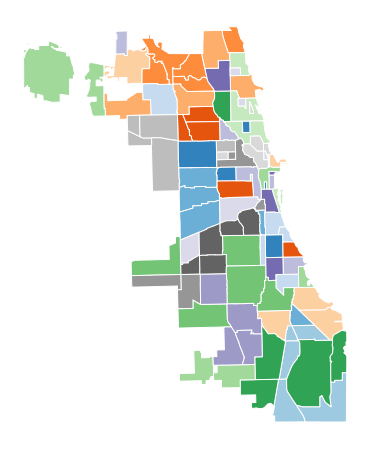

In [235]:
style_kwds = {'edgecolor':'white', 
                'facecolor':'k',
                'linewidth': 1, 
                'markersize': 1, 
                'alpha': 1}

fig, ax = plt.subplots(figsize=(8,8))
chi.plot(ax=ax,
        cmap='tab20c',
        **style_kwds)
ax.axis('off')

In [236]:
chi.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Data Cleaning

## Dropping columns

The Chicago geojson dataset consists of the columns [`created_at`, `updated_at`] which we don't need. We will drop them to save space.

In [237]:
chi.drop(['created_at', 'updated_at'], axis=1, inplace=True)

## Renaming columns

I am not the greatest fan of "strings with space" column names, because it's difficult to prompt in a df.column_name format. I will instead convert them into one lowercase string where substrings are separated using underscores.

In [238]:
df = df.rename(columns={col: col.lower().replace(' ', '_') for col in df.columns})
df.columns

Index(['taxi_id', 'trip_start_timestamp', 'trip_end_timestamp', 'trip_miles',
       'trip_total', 'pickup_centroid_location', 'dropoff_centroid__location'],
      dtype='object')

## Taxi ID

The Taxi IDs are these long strings. According to the [data description](https://data.cityofchicago.org/Transportation/Taxi-Trips-2019/h4cq-z3dy):
> to protect privacy but allow for aggregate analyses, the Taxi ID is consistent for any given taxi medallion number but does not show the number

Since we are only going to be using this data for data analysis/visualisations, and not any complex modelling where patterns within these long strings might become relevant, we are just going to simplify our lives by replacing them with integers. We use the `OrdinalEncoder` function from `sklearn.preprocessing` to do this.  

In [239]:
print("Number of unique taxi_id numbers: ", df.taxi_id.nunique())

Number of unique taxi_id numbers:  4570


In [240]:
from sklearn.preprocessing import OrdinalEncoder


# Apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder()
df['taxi_id'] = ordinal_encoder.fit_transform(df[['taxi_id']])
print("Number of unique taxi_id numbers: ", df.taxi_id.nunique())
print("The Unique taxi_id numbers: ", df.taxi_id.unique())

Number of unique taxi_id numbers:  4570
The Unique taxi_id numbers:  [2040. 2419. 3452. ... 4148. 1586. 1835.]


In [241]:
df.tail()

,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_miles,trip_total,pickup_centroid_location,dropoff_centroid__location
1532332,2752.0,2019-05-31 23:45:00,2019-06-01 00:15:00,13.25,39.50,POINT (-87.7509342894 41.785998518),POINT (-87.6321092196 41.9002656868)
1532333,4182.0,2019-05-31 23:45:00,2019-06-01 00:15:00,0.00,18.75,POINT (-87.6378442095 41.8932163595),POINT (-87.6188683546 41.8909220259)
1532334,1995.0,2019-05-31 23:45:00,2019-06-01 00:00:00,1.20,8.25,POINT (-87.6318639497 41.8920421365),POINT (-87.6499072264 41.9049353016)
1532335,1805.0,2019-05-31 23:45:00,2019-06-01 00:30:00,0.90,49.25,POINT (-87.9030396611 41.9790708201),POINT (-87.6517705068 41.9426918444)
1532336,3429.0,2019-05-31 23:45:00,2019-06-01 00:15:00,12.95,43.25,POINT (-87.7509342894 41.785998518),POINT (-87.6262149064 41.8925077809)


## Adding Neighbourhood information/geometries to Reservations data

This involves:
* Converting the dtypes of the columns `pickup_centroid_location` and `dropoff_centroid__location` from `str` to `geometry` by using the `gpd.GeoSeries.from_wkt` function
* Locating the neighbourhood within which a particular POINT is located and assigning that neighbourhood to that location. This is done in two steps, because this involves converting the dataframe from the previous step into a geodataframe, and a geodataframe can only recognise one 'geomtry' column at a time:
  * Convert df into a geodataframe with `pickup_centroid_location` as geometry and performing an inner sjoin to assign the `pickup_nbd`
  * Convert df into a geodataframe with `dropoff_centroid__location` as geometry and performing an inner sjoin to assign the `dropoff_nbd`

In [242]:
# Converting dtype to 'geometry'

df['pickup_centroid_location'] = gpd.GeoSeries.from_wkt(df['pickup_centroid_location'])
df['dropoff_centroid__location'] = gpd.GeoSeries.from_wkt(df['dropoff_centroid__location'])

# Starting neighbourhood

## Converting to geodataframe with geometry column = 'pickup_centroid_location' 
df = gpd.GeoDataFrame(df, geometry=df['pickup_centroid_location'], crs="EPSG:4326")

## Adding neighbourhoods by locating points within them
df = gpd.sjoin(df, chi, how='inner')

## Dropping columns
df.drop(['geometry', 'index_right', 'cartodb_id'], axis=1, inplace=True)
 
## Merging with neighbourhood geojson
df = df.merge(chi, on='name')


## Renaming columns
df.rename(columns={'geometry':'pickup_nbd_geometry',
                    'name': 'pickup_nbd_name',
                    'cartodb_id': 'pickup_nbd_cartodb_id'}, inplace=True)

# Ending neighbourhood

## Converting to geodataframe with geometry column = 'dropoff_centroid__location' 
df = gpd.GeoDataFrame(df, geometry=df['dropoff_centroid__location'], crs="EPSG:4326")

## Joining starting neighbourhoods
df = gpd.sjoin(df, chi, how='inner')

## Dropping columns
df.drop(['geometry', 'index_right', 'cartodb_id'], axis=1, inplace=True)

## Merging with neighbourhood geojson
df = df.merge(chi, on='name')

## Renaming columns
df.rename(columns={'geometry':'dropoff_nbd_geometry',
                    'name': 'dropoff_nbd_name',
                    'cartodb_id': 'dropoff_nbd_cartodb_id'}, inplace=True)


/Users/abhirupghosh/opt/anaconda3/envs/MM22/lib/python3.10/site-packages/geopandas/geodataframe.py:1487: FutureWarning: Accessing CRS of a GeoDataFrame without a geometry column is deprecated and will be removed in GeoPandas 0.12. Use GeoDataFrame.set_geometry to set the active geometry column.
  result.crs = self.crs
/Users/abhirupghosh/opt/anaconda3/envs/MM22/lib/python3.10/site-packages/geopandas/geodataframe.py:1487: FutureWarning: Accessing CRS of a GeoDataFrame without a geometry column is deprecated and will be removed in GeoPandas 0.12. Use GeoDataFrame.set_geometry to set the active geometry column.
  result.crs = self.crs


# Final dataset

In [243]:
df.info()
df.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1378763 entries, 0 to 1378762
Data columns (total 13 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   taxi_id                     1378762 non-null  float64       
 1   trip_start_timestamp        1378763 non-null  datetime64[ns]
 2   trip_end_timestamp          1378763 non-null  datetime64[ns]
 3   trip_miles                  1378719 non-null  float64       
 4   trip_total                  1378646 non-null  float64       
 5   pickup_centroid_location    1378763 non-null  geometry      
 6   dropoff_centroid__location  1378763 non-null  geometry      
 7   pickup_nbd_name             1378763 non-null  object        
 8   pickup_nbd_cartodb_id       1378763 non-null  int64         
 9   pickup_nbd_geometry         1378763 non-null  geometry      
 10  dropoff_nbd_name            1378763 non-null  object        
 11  dropoff_nbd_cart

,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_miles,trip_total,pickup_centroid_location,dropoff_centroid__location,pickup_nbd_name,pickup_nbd_cartodb_id,pickup_nbd_geometry,dropoff_nbd_name,dropoff_nbd_cartodb_id,dropoff_nbd_geometry
0,2580.0,2019-05-01 00:00:00,2019-05-01 00:15:00,11.60,41.70,POINT (-87.76962 41.79259),POINT (-87.62519 41.87887),Garfield Ridge,45,"MULTIPOLYGON (((-87.73856 41.81871, -87.73853 ...",Loop,54,"MULTIPOLYGON (((-87.61397 41.88841, -87.61325 ..."
1,2639.0,2019-05-01 00:15:00,2019-05-01 00:30:00,0.60,40.20,POINT (-87.75093 41.78600),POINT (-87.63275 41.88099),Garfield Ridge,45,"MULTIPOLYGON (((-87.73856 41.81871, -87.73853 ...",Loop,54,"MULTIPOLYGON (((-87.61397 41.88841, -87.61325 ..."
2,4494.0,2019-05-01 00:15:00,2019-05-01 00:30:00,10.83,42.90,POINT (-87.75093 41.78600),POINT (-87.63275 41.88099),Garfield Ridge,45,"MULTIPOLYGON (((-87.73856 41.81871, -87.73853 ...",Loop,54,"MULTIPOLYGON (((-87.61397 41.88841, -87.61325 ..."
3,1264.0,2019-05-01 00:30:00,2019-05-01 00:45:00,10.80,40.60,POINT (-87.75093 41.78600),POINT (-87.63275 41.88099),Garfield Ridge,45,"MULTIPOLYGON (((-87.73856 41.81871, -87.73853 ...",Loop,54,"MULTIPOLYGON (((-87.61397 41.88841, -87.61325 ..."
4,1980.0,2019-05-01 00:30:00,2019-05-01 01:00:00,12.60,47.75,POINT (-87.75093 41.78600),POINT (-87.62099 41.88499),Garfield Ridge,45,"MULTIPOLYGON (((-87.73856 41.81871, -87.73853 ...",Loop,54,"MULTIPOLYGON (((-87.61397 41.88841, -87.61325 ..."


# Geo-spatial analysis

## Neighbourhood: Trip-starts/ends

In [257]:
gdf_starts = (df.groupby(['pickup_nbd_name']).agg({'pickup_nbd_geometry': lambda x: x.iloc[0],
                                    'taxi_id':pd.Series.nunique,
                                    'trip_miles': 'sum',
                                    'trip_total': 'sum',
                                    'trip_start_timestamp':'count'})
                                .rename(columns={'pickup_nbd_geometry': 'geometry',
                                                'taxi_id': 'cars',
                                                'trip_miles': 'total_dist',
                                                'trip_total': 'total_rev',
                                                'trip_start_timestamp': 'total_trips'})
                                .reset_index()
                                .set_geometry("geometry")
)

gdf_ends = (df.groupby(['dropoff_nbd_name']).agg({'dropoff_nbd_geometry': lambda x: x.iloc[0],
                                    'taxi_id':pd.Series.nunique,
                                    'trip_miles': 'sum',
                                    'trip_total': 'sum',
                                    'trip_start_timestamp':'count'})
                                .rename(columns={'dropoff_nbd_geometry': 'geometry',
                                                'taxi_id': 'cars',
                                                'trip_miles': 'total_dist',
                                                'trip_total': 'total_rev',
                                                'trip_start_timestamp': 'total_trips'})
                                .reset_index()
                                .set_geometry("geometry")
)

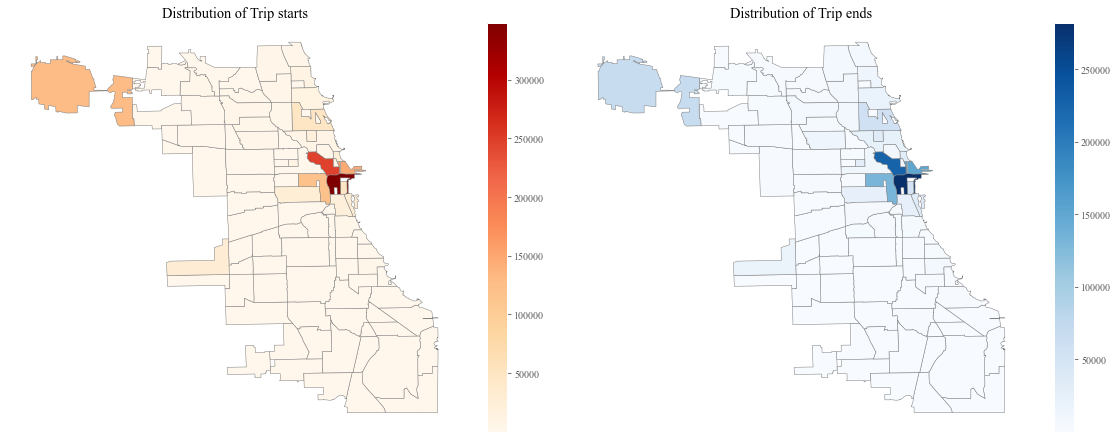

In [311]:
style_kwds = {'edgecolor':'grey', 
                'facecolor':'k',
                'linewidth': 0.5, 
                'markersize': 1, 
                'alpha': 1}

fig, ax = plt.subplots(ncols=2, figsize=(16,6))
gdf_starts.plot(column='total_trips',
        ax=ax[0],
        cmap='OrRd',
        legend=True,
        **style_kwds)
ax[0].grid(False)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_facecolor('w')
ax[0].set_title('Distribution of Trip starts') 

gdf_ends.plot(column='total_trips',
        ax=ax[1],
        cmap='Blues',
        legend=True,
        **style_kwds)
ax[1].grid(False)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_facecolor('w')
ax[1].set_title('Distribution of Trip ends')

plt.tight_layout()
